<a href="https://colab.research.google.com/github/Gaukhar-ai/Capstone/blob/master/algorithmic_trading_bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpha_vantage

In [2]:
!pip install backtrader

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os
from alpha_vantage.foreignexchange import ForeignExchange
import warnings

%matplotlib inline

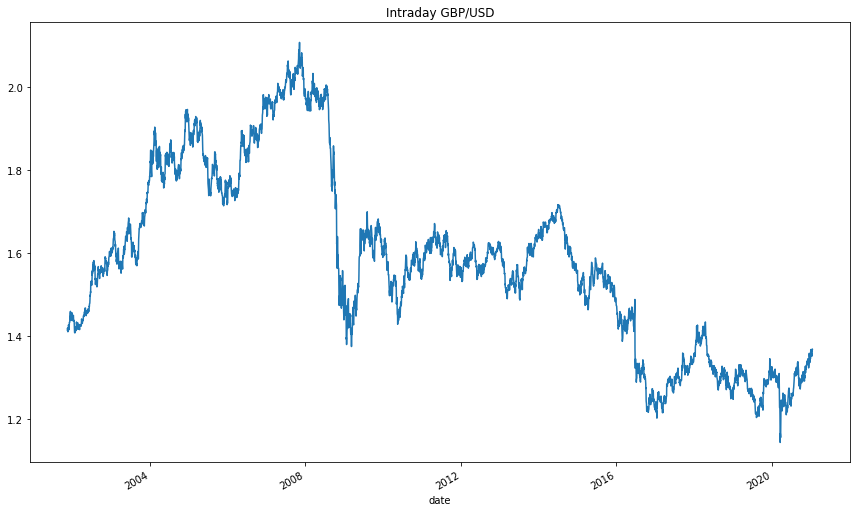

In [4]:
alpha = 'alpha_vantage_key'
cc = ForeignExchange(key=alpha, output_format
                     ='pandas')
#retrieve daily OHLC (open high, low close prices)

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',
                                                      to_symbol='USD',
                                                      outputsize='full')
#plot
data_df['4. close'].plot(figsize=(12,7))
plt.tight_layout()
plt.title('Intraday GBP/USD')
plt.show()

In [5]:
data_df.sort_index(inplace=True)
data_df = data_df.loc['2015-01-01':]

#rename and rearrange the fields for backtrader to be ingested

data_df=data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns=['High', 'Low', 'Open', 'Close']

class boll_bander(bt.Strategy):
set a bollinger band indicator, buy when the price exceeds the lower band, sell when price exceeds higher band. 

set the params for the bollinder band. Can be 21 days = number of days in a trading month, a smaller std on the band. Gives more entry and exit opportunities.

In [6]:
class boll_bander(bt.Strategy):
  params = dict(
    bperiod=21
    ,dev=1.25)

def __init__(self):

  #define bollinger band

  self.boll = bt.ind.BollinderBands(period = self.p.bperiod, devfactor=
                                    self.p.dev, plot=True, plotname='Bollinger Band',
                                    subplot=False)
  #define cross over points
  self.buysig = bt.indicators.CrossOver(self.data0, self.boll.lines.bot,
                                        plotname='buy signal', plot=True)
  self.sellsig = bt.indicators.CrossOver(self.data0, self.boll.lines.top,
                                         plotname = 'sell signal', plot=True)
  
  def next(self):
    if not self.position: #not in the market
      if self.buysig>0: #if fast crosses slow to the upside
        self.order_target_size(target=3000) #enter long
    elif self.selling>0: #in the market and cross to the downside
      self.order_target_size(target=0) #close long position

backtesing: $10,000 for starting capital

In [7]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(boll_bander)
results=cerebro.run()

In [ ]:
print(f"Sharpe:{results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return:{results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=False, volume=False, width=20)